[Project Page](https://www.kaggle.com/competitions/blood-vessel-segmentation)  
[Google Doc](https://docs.google.com/document/d/1QiBUwSoZnzDt6wrNvFiOegdJ5592CiDX)

## Import

In [1]:
import os
import cv2
import time
import numpy as np
import pandas as pd
import albumentations as A
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from typing import Callable
from torchvision import models
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, random_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Pre-setup

### Defining Constant Variables

In [2]:
DATASET_PATH = '/kaggle/input/blood-vessel-segmentation/'
SPLIT_RATIO = 0.7

### Setting torch backend accelerator

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print('Current backend accelerator:', device)

Current backend accelerator: cuda


## Data Preparation

### Define Preprocessor

In [4]:
def preprocess_image(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    img = np.tile(img[...,None],[1, 1, 3]) 
    img = img.astype('float32') 
    mx = np.max(img)
    if mx:
        img/=mx 

    img = np.transpose(img, (2, 0, 1))
    img_ten = torch.tensor(img)
    return img_ten

def preprocess_mask(path):
    msk = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    msk = msk.astype('float32')
    msk/=255.0
    msk_ten = torch.tensor(msk)
    return msk_ten

### Augmentation

In [5]:
def augment_image(image, mask):
    image_np = image.permute(1, 2, 0).numpy()
    mask_np = mask.numpy()

    transform = A.Compose([
        A.Resize(256,256, interpolation=cv2.INTER_NEAREST),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),
        A.RandomCrop(height=256, width=256, always_apply=True),
        A.RandomBrightness(p=1),
        A.OneOf(
            [
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),
    
    ])

    augmented = transform(image=image_np, mask=mask_np)
    augmented_image, augmented_mask = augmented['image'], augmented['mask']

    augmented_image = torch.tensor(augmented_image, dtype=torch.float32).permute(2, 0, 1)
    augmented_mask = torch.tensor(augmented_mask, dtype=torch.float32)

    return augmented_image, augmented_mask

### Define Dataset

In [6]:
class KidneyDataset(Dataset):
    def __init__(self, dataset: str, transform: Callable=None) -> None:
        '''
        Args:
            datset (str): Dataset. Eg) kidney_1_dense, kidney_2, etc...
            transform (Callable, optional): Optional transformer for iamges
        '''
        self.dataset = dataset
        self.transform = transform

        # Load images and labels.
        images_path = os.path.join(DATASET_PATH, dataset, 'images')
        labels_path = os.path.join(DATASET_PATH, dataset, 'labels')
        self.image_files = sorted([os.path.join(images_path, f) for f in os.listdir(images_path) if f.endswith('.tif')])
        self.label_files = sorted([os.path.join(labels_path, f) for f in os.listdir(labels_path) if f.endswith('.tif')])

    def __len__(self) -> int:
        return len(self.image_files)

    def __getitem__(self, idx: int):
        # Load image and mask.
        image = preprocess_image(self.image_files[idx])
        mask = preprocess_mask(self.label_files[idx])

        if self.transform:
            image, mask = self.transform(image, mask)

        return image, mask

    def get_path(self, idx: int):
        return self.image_files[idx], self.label_files[idx]


### Load Dataset

In [7]:
dataset = KidneyDataset(dataset='train/kidney_1_dense', transform=augment_image)

train_size = int(SPLIT_RATIO * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [8]:
# test_image, test_mask = dataset.get_path(10)
# test_image = Image.open(test_image)
# test_mask = Image.open(test_mask)

# test_image.show()
# test_mask.show()

/opt/conda/lib/python3.10/site-packages/albumentations/augmentations/transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


Batch 1
Image batch shape: torch.Size([8, 3, 256, 256])
Mask batch shape: torch.Size([8, 256, 256])


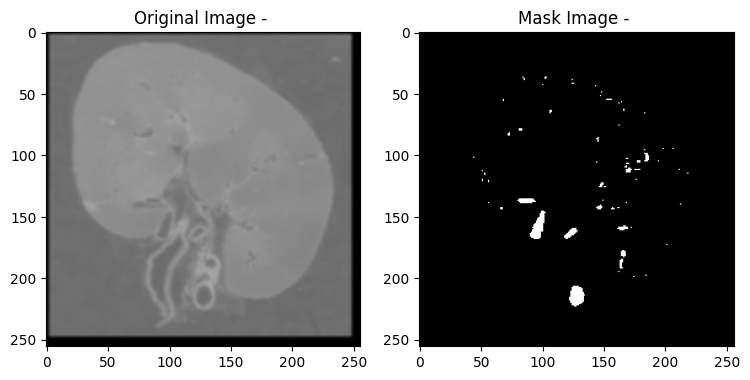

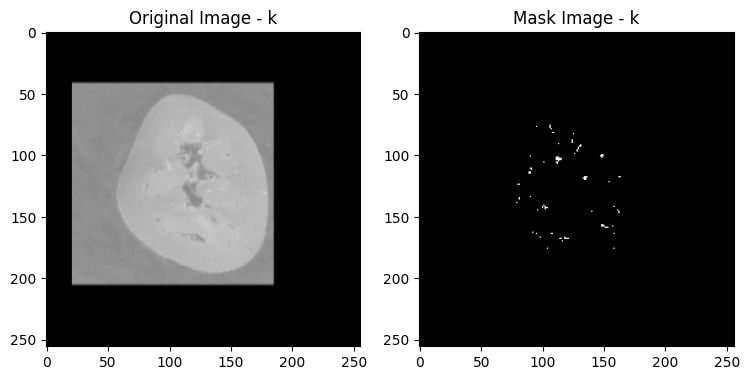

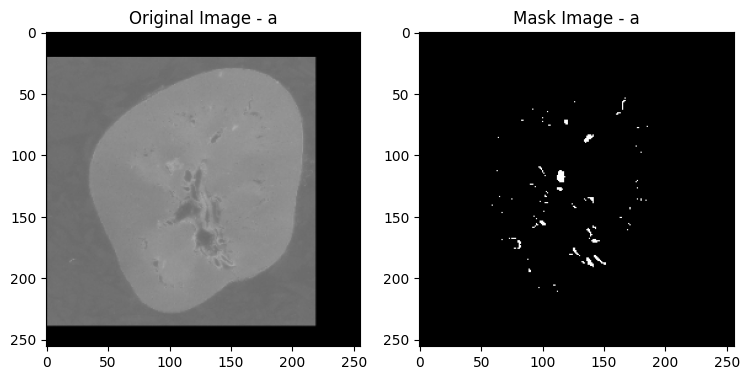

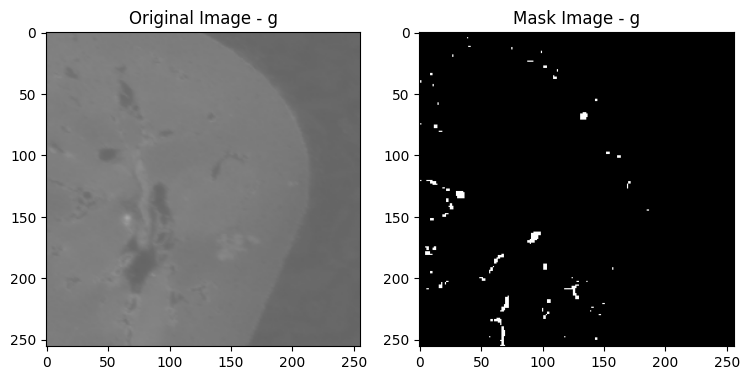

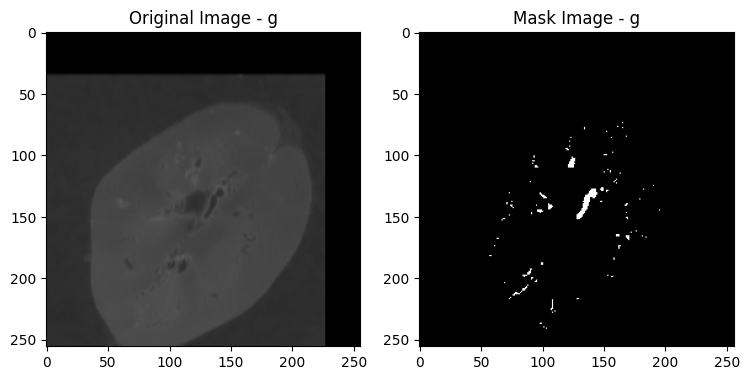

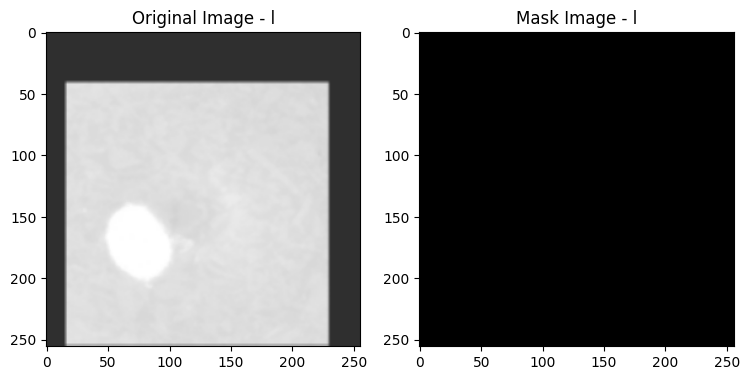

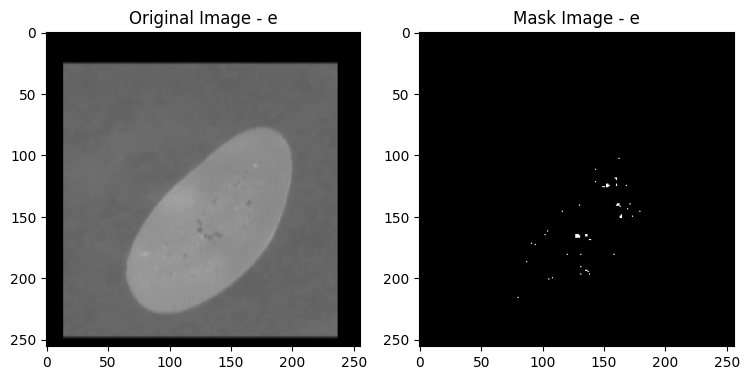

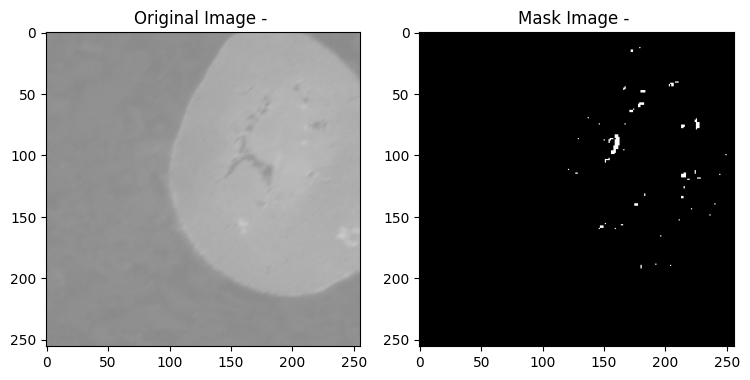

In [9]:
for batch_idx, (batch_images, batch_masks) in enumerate(train_dataloader):
    print("Batch", batch_idx + 1)
    print("Image batch shape:", batch_images.shape)
    print("Mask batch shape:", batch_masks.shape)
    
    for image, mask, image_path, mask_path in zip(batch_images, batch_masks, *dataset.get_path(batch_idx)):
       
        image = image.permute((1, 2, 0)).numpy()*255.0
        image = image.astype('uint8')
        mask = (mask*255).numpy().astype('uint8')
        
        image_filename = os.path.basename(image_path)
        mask_filename = os.path.basename(mask_path)
        
        plt.figure(figsize=(15, 10))
        
        plt.subplot(2, 4, 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"Original Image - {image_filename}")
        
        plt.subplot(2, 4, 2)
        plt.imshow(mask, cmap='gray')
        plt.title(f"Mask Image - {mask_filename}")
        
        plt.tight_layout()
        plt.show()
    break

## Attention U-Net architecture

In [10]:
# # CNN Model Definition
# class CNN(nn.Module):
#     def __init__(self, input_size: int, num_classes: int):
#         super(CNN, self).__init__()
#         self.conv_layers = nn.Sequential(
#             nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(32),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2),
#             nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2),
#             nn.Conv2d(64, input_size, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(input_size),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2)
#         )
#         self.fc_layers = nn.Sequential(
#             nn.Linear(512000, 1024),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(1024, num_classes)
#         )

#     def forward(self, x):
#         x = self.conv_layers(x)
#         x = x.view(x.size(0), -1)  # Flatten the tensor
#         x = self.fc_layers(x)
#         return x

# model = CNN(IMAGE_SIZE, len(dataset.labels))
# model.to(device); # Connect to the backend hardware accelerator

In [11]:
class ConvBlock(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class UpConv(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(UpConv, self).__init__()

        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x


class AttentionBlock(nn.Module):
    """Attention block with learnable parameters"""

    def __init__(self, F_g, F_l, n_coefficients):
        """
        :param F_g: number of feature maps (channels) in previous layer
        :param F_l: number of feature maps in corresponding encoder layer, transferred via skip connection
        :param n_coefficients: number of learnable multi-dimensional attention coefficients
        """
        super(AttentionBlock, self).__init__()

        self.W_gate = nn.Sequential(
            nn.Conv2d(F_g, n_coefficients, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(n_coefficients)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, n_coefficients, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(n_coefficients)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(n_coefficients, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, gate, skip_connection):
        """
        :param gate: gating signal from previous layer
        :param skip_connection: activation from corresponding encoder layer
        :return: output activations
        """
        g1 = self.W_gate(gate)
        x1 = self.W_x(skip_connection)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        out = skip_connection * psi
        return out


class AttentionUNet(nn.Module):

    def __init__(self, img_ch=3, output_ch=1):
        super(AttentionUNet, self).__init__()

        self.MaxPool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.Conv1 = ConvBlock(img_ch, 64)
        self.Conv2 = ConvBlock(64, 128)
        self.Conv3 = ConvBlock(128, 256)
        self.Conv4 = ConvBlock(256, 512)
        self.Conv5 = ConvBlock(512, 1024)

        self.Up5 = UpConv(1024, 512)
        self.Att5 = AttentionBlock(F_g=512, F_l=512, n_coefficients=256)
        self.UpConv5 = ConvBlock(1024, 512)

        self.Up4 = UpConv(512, 256)
        self.Att4 = AttentionBlock(F_g=256, F_l=256, n_coefficients=128)
        self.UpConv4 = ConvBlock(512, 256)

        self.Up3 = UpConv(256, 128)
        self.Att3 = AttentionBlock(F_g=128, F_l=128, n_coefficients=64)
        self.UpConv3 = ConvBlock(256, 128)

        self.Up2 = UpConv(128, 64)
        self.Att2 = AttentionBlock(F_g=64, F_l=64, n_coefficients=32)
        self.UpConv2 = ConvBlock(128, 64)

        self.Conv = nn.Conv2d(64, output_ch, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        """
        e : encoder layers
        d : decoder layers
        s : skip-connections from encoder layers to decoder layers
        """
        e1 = self.Conv1(x)

        e2 = self.MaxPool(e1)
        e2 = self.Conv2(e2)

        e3 = self.MaxPool(e2)
        e3 = self.Conv3(e3)

        e4 = self.MaxPool(e3)
        e4 = self.Conv4(e4)

        e5 = self.MaxPool(e4)
        e5 = self.Conv5(e5)

        d5 = self.Up5(e5)

        s4 = self.Att5(gate=d5, skip_connection=e4)
        d5 = torch.cat((s4, d5), dim=1) 
        d5 = self.UpConv5(d5)

        d4 = self.Up4(d5)
        s3 = self.Att4(gate=d4, skip_connection=e3)
        d4 = torch.cat((s3, d4), dim=1)
        d4 = self.UpConv4(d4)

        d3 = self.Up3(d4)
        s2 = self.Att3(gate=d3, skip_connection=e2)
        d3 = torch.cat((s2, d3), dim=1)
        d3 = self.UpConv3(d3)

        d2 = self.Up2(d3)
        s1 = self.Att2(gate=d2, skip_connection=e1)
        d2 = torch.cat((s1, d2), dim=1)
        d2 = self.UpConv2(d2)

        out = self.Conv(d2)

        return out

## Evaulator

In [12]:
def dice_coeff(prediction, target):
    mask = np.zeros_like(prediction)
    mask[prediction >= 0.5] = 1

    inter = np.sum(mask * target)
    union = np.sum(mask) + np.sum(target)
    epsilon = 1e-6
    result = np.mean(2 * inter / (union + epsilon))
    return result

In [13]:
class FocalLoss(nn.modules.loss._WeightedLoss):
    def __init__(self, gamma=0, size_average=None, ignore_index=-100,
                 reduce=None, balance_param=1.0):
        super(FocalLoss, self).__init__(size_average)
        self.gamma = gamma
        self.size_average = size_average
        self.ignore_index = ignore_index
        self.balance_param = balance_param

    def forward(self, input, target):
        assert len(input.shape) == len(target.shape)
        assert input.size(0) == target.size(0)
        assert input.size(1) == target.size(1)

        logpt = - F.binary_cross_entropy_with_logits(input, target)
        pt = torch.exp(logpt)

        focal_loss = -((1 - pt) ** self.gamma) * logpt
        balanced_focal_loss = self.balance_param * focal_loss
        return balanced_focal_loss

In [14]:
dataloaders = {
    'training': train_dataloader,
    'test': val_dataloader
}

## Training and Testing Loop

In [15]:
def train_and_test(model, dataloaders, optimizer, criterion, num_epochs=100, show_images=False):
    since = time.time()
    best_loss = 1e10

    model.to(device)

    fieldnames = ['epoch', 'training_loss', 'test_loss', 'training_dice_coeff', 'test_dice_coeff']
    train_epoch_losses = []
    test_epoch_losses = []
    for epoch in range(1, num_epochs + 1):

        print(f'Epoch {epoch}/{num_epochs}')
        print('-' * 10)
        
        batchsummary = {a: [0] for a in fieldnames}
        batch_train_loss = 0.0
        batch_test_loss = 0.0

        for phase in ['training', 'test']:
            if phase == 'training':
                model.train()  
            else:
                model.eval() 

            for sample in iter(dataloaders[phase]):

                if show_images:
                    grid_img = make_grid(sample[0])
                    grid_img = grid_img.permute(1, 2, 0)
                    plt.imshow(grid_img)
                    plt.show()

                inputs = sample[0].to(device)
                masks = sample[1].to(device)
                
                masks = masks.unsqueeze(1)
                
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'training'):
                    outputs = model(inputs)

                    loss = criterion(outputs, masks)

                    y_pred = outputs.data.cpu().numpy().ravel()
                    y_true = masks.data.cpu().numpy().ravel()

                    batchsummary[f'{phase}_dice_coeff'].append(dice_coeff(y_pred, y_true))

                    if phase == 'training':
                        loss.backward()
                        optimizer.step()

                        batch_train_loss += loss.item() * sample[0].size(0)

                    else:
                        batch_test_loss += loss.item() * sample[0].size(0)

            if phase == 'training':
                epoch_train_loss = batch_train_loss / len(dataloaders['training'])
                train_epoch_losses.append(epoch_train_loss)
            else:
                epoch_test_loss = batch_test_loss / len(dataloaders['test'])
                test_epoch_losses.append(epoch_test_loss)

            batchsummary['epoch'] = epoch
            
            print('{} Loss: {:.4f}'.format(phase, loss))

        best_loss = np.max(batchsummary['test_dice_coeff'])
        for field in fieldnames[3:]:
            batchsummary[field] = np.mean(batchsummary[field])
        print(
            f'\t\t\t train_dice_coeff: {batchsummary["training_dice_coeff"]}, test_dice_coeff: {batchsummary["test_dice_coeff"]}')

    print('Best dice coefficient: {:4f}'.format(best_loss))

    return model, train_epoch_losses, test_epoch_losses

In [16]:
epochs = 25

def train():
    model = AttentionUNet()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = FocalLoss(gamma=2)

    trained_model, train_epoch_losses, test_epoch_losses = train_and_test(model, dataloaders, optimizer, criterion, num_epochs=epochs)

    return trained_model, train_epoch_losses, test_epoch_losses


trained_model, train_epoch_losses, test_epoch_losses = train()

Epoch 1/25
----------
training Loss: 0.0340
test Loss: 0.0309
			 train_dice_coeff: 0.0003623063567480845, test_dice_coeff: 0.0
Epoch 2/25
----------
training Loss: 0.0199
test Loss: 0.0193
			 train_dice_coeff: 2.754775402398707e-06, test_dice_coeff: 0.0
Epoch 3/25
----------
training Loss: 0.0124
test Loss: 0.0120
			 train_dice_coeff: 0.0, test_dice_coeff: 0.0
Epoch 4/25
----------
training Loss: 0.0088
test Loss: 0.0079
			 train_dice_coeff: 0.0, test_dice_coeff: 0.0
Epoch 5/25
----------
training Loss: 0.0070
test Loss: 0.0053
			 train_dice_coeff: 0.0, test_dice_coeff: 0.0
Epoch 6/25
----------
training Loss: 0.0051
test Loss: 0.0040
			 train_dice_coeff: 0.0, test_dice_coeff: 0.0
Epoch 7/25
----------
training Loss: 0.0037
test Loss: 0.0032
			 train_dice_coeff: 0.0, test_dice_coeff: 0.0
Epoch 8/25
----------
training Loss: 0.0025
test Loss: 0.0025
			 train_dice_coeff: 0.0, test_dice_coeff: 0.0
Epoch 9/25
----------
training Loss: 0.0025
test Loss: 0.0021
			 train_dice_coeff: 

In [17]:
torch.save(trained_model.state_dict(), 'trained_model.pth')

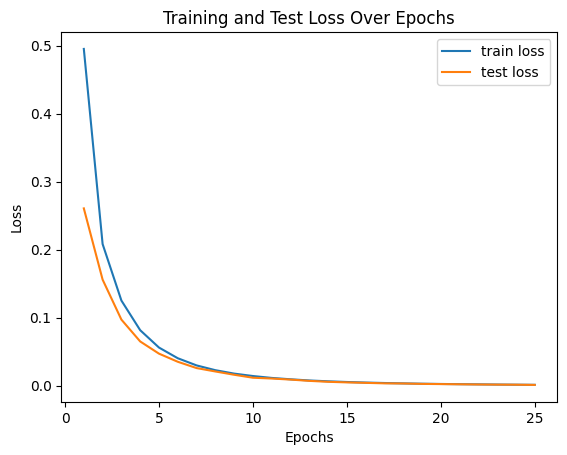

In [18]:
train_plot, = plt.plot(range(1, len(train_epoch_losses) + 1), train_epoch_losses, label='train loss')
test_plot, = plt.plot(range(1, len(test_epoch_losses) + 1), test_epoch_losses, label='test loss')
plt.legend(handles=[train_plot, test_plot])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Epochs')
plt.show()

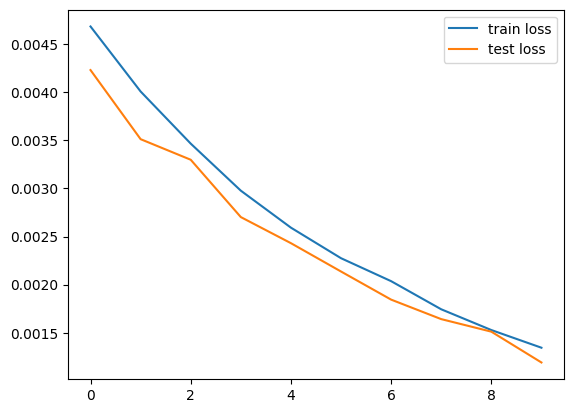

In [19]:
train_plot, = plt.plot(range(len(train_epoch_losses)-15), train_epoch_losses[15:], label='train loss')
test_plot, = plt.plot(range(len(test_epoch_losses)-15), test_epoch_losses[15:], label='test loss')
plt.legend(handles=[train_plot, test_plot])
plt.show()